# This is Part 4 Notepook - Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time  
import ast
import pytz

import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from sklearn.metrics import precision_recall_curve, make_scorer
from sklearn.metrics import roc_curve, auc


from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\encoded_w_outliers.csv")

In [3]:
df.head()

,user_is_clicker,premium_inventory,target,bun_ctr_30d_log,u_imp_depth_offer_d90_log,u_click_depth_camp_d90_log,request_make_Alcatel,request_make_Apple,request_make_Asus,request_make_Azom Tech,...,user_primary_category_d90_83.0,user_primary_category_d90_84.0,user_primary_category_d90_85.0,user_primary_category_d90_86.0,user_primary_category_d90_87.0,user_primary_category_d90_88.0,user_primary_category_d90_89.0,user_primary_category_d90_90.0,user_primary_category_d90_95.0,user_primary_category_d90_162.0
0,0,1,0,-0.394520,-0.434509,-1.337736,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,-0.392433,0.854457,-1.337736,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,-0.322164,-1.212932,-1.337736,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,-0.395738,-0.005031,-1.337736,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,-0.395613,-0.325286,0.335603,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9804 entries, 0 to 9803
Columns: 246 entries, user_is_clicker to user_primary_category_d90_162.0
dtypes: float64(3), int64(243)
memory usage: 18.4 MB


In [5]:
X = df.drop(['target'],axis=1)
y = df['target']

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [7]:
X_train.shape

(6862, 245)

In [8]:
X_test.shape

(2942, 245)

In [9]:
#Let us define a dataframe to store performance of our future awesome models
columns = ['Model Name', 'Elapsed Time', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Log Loss']
performance_df = pd.DataFrame(columns=columns)

In [10]:
# Function to add model's performance to the DataFrame
def add_model_performance(performance_df, model_name, elapsed_time, accuracy, precision, recall, f1, roc_auc, log_loss_value):
    new_row = {
        'Model Name': model_name,
        'Elapsed Time': elapsed_time,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Log Loss': log_loss_value
    }
    return performance_df.append(new_row, ignore_index=True)

In [11]:
def summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df):
    """
    Summarize and plot the performance of a trained model and add its performance metrics to an existing DataFrame.

    Parameters:
    model (Classifier): The trained model.
    X_test (DataFrame): Test features.
    y_test (Series): True labels for the test set.
    model_name (str): Name of the model.
    elapsed_time (float): Training time for the model.
    performance_df (DataFrame): DataFrame to store performance metrics.

    Returns:
    DataFrame: Updated performance DataFrame with the new model's metrics.
    """

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Compute the confusion matrix
    confusion = confusion_matrix(y_test, y_pred)

    # Compute ROC curve and ROC AUC
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Create a figure with two subplots for confusion matrix and ROC curve
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the confusion matrix
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Plot the ROC curve
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.0])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # Compute main metrics 
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_prob)

    # Update the performance DataFrame
    performance_df = add_model_performance(performance_df, model_name, elapsed_time, accuracy, precision, recall, f1, roc_auc, log_loss_value)

    return performance_df

# Baseline Model

Before we build our first model, we want to create a dummy classifier baseline

In [12]:
model_name = "Baseline"

# Create a dummy classifier that predicts the majority class (0)
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Start the timer
start_time = time.time()

# Train the dummy classifier on the training data
dummy_classifier.fit(X_train, y_train)

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time

In [13]:
elapsed_time

0.0009975433349609375

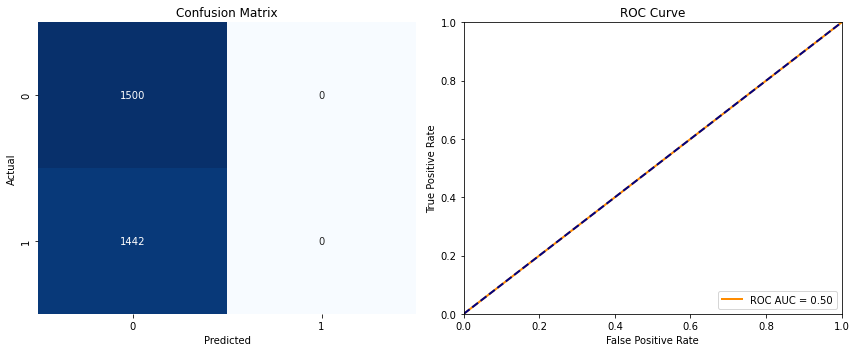

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.0,0.0,0.0,0.5,16.928931


In [14]:
model = dummy_classifier
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
- As expected, the dummy classifier classifies everything as Class 0 (majority class)
- The metrics are pretty bad too

# Decision Tree - Basic

In [15]:
model_name = "Decision Tree - Basic"

# Start the timer
start_time = time.time()

# Create a DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_classifier.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

Elapsed Time: 0.05684709548950195


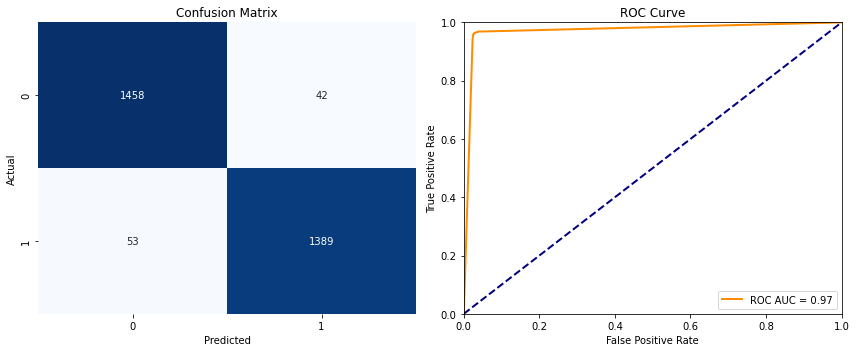

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.00000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.056847,0.967709,0.97065,0.963245,0.966934,0.967623,0.951416


In [16]:
# Let us check performance
model = dt_classifier
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

# Observation:
- Not too shabby! Basic Decision Tree perforamance against Test data is very nice!
- Compared to the dummy classifier, LogLoss dropped from 16.93 to 0.9

# Decision Tree - Optimized

In [17]:
model_name = "Decision Tree - Optimized"

# Start the timer
start_time = time.time()

# Define the hyperparameters and their possible values
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(5, 51, 5)),
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Create a GridSearchCV object with custom scoring
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='neg_log_loss'
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Get the best estimator (best model)
best_dt_classifier = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 440 candidates, totalling 2200 fits
Elapsed Time: 29.725759029388428
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}


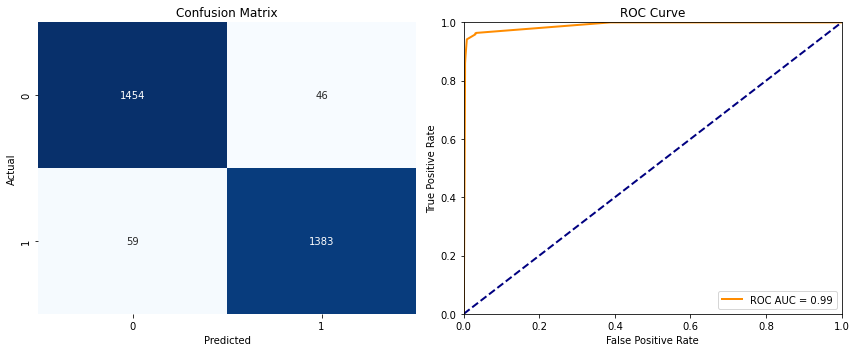

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.00000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.056847,0.967709,0.97065,0.963245,0.966934,0.967623,0.951416
2,Decision Tree - Optimized,29.725759,0.964310,0.96781,0.959085,0.963427,0.964209,0.145982


In [18]:
# Let us check performance
model = best_dt_classifier
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
LogLoss Improved quite a bit from 0.9 for unoptimized tree to just 0.15 

# Random Forest - Basic

In [19]:
model_name = "Random Forest - Basic"

# Start the timer
start_time = time.time()

# Create a RandomForestClassifier with default parameters
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

Elapsed Time: 0.7039332389831543


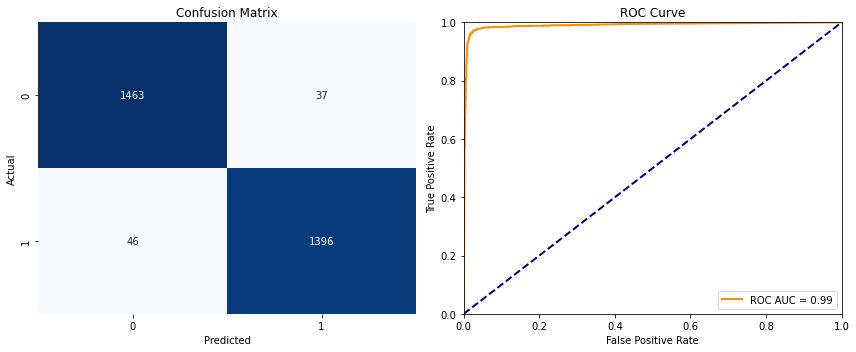

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.00000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.056847,0.967709,0.97065,0.963245,0.966934,0.967623,0.951416
2,Decision Tree - Optimized,29.725759,0.964310,0.96781,0.959085,0.963427,0.964209,0.145982
3,Random Forest - Basic,0.703933,0.971788,0.97418,0.968100,0.971130,0.971717,0.211232


In [20]:
# Let us check performance
model = rf_classifier
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
- LogLoss for Basic Random Forest is quite a bit better than for Basic Tree (0.2 vs 0.9). However, it is still worse than the optimise Tree LogLos, which was 0.15.
- All other parameters look great. 
- Let us see if we can further finetune the model through Hyperparameter Tuning

# Random Forest - Optimized

In [21]:
model_name = "Random Forest - Optimized"

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
    # Add other parameters if needed
}

# Create a GridSearchCV object with LogLoss scoring
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='neg_log_loss'
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Get the best estimator (best model)
best_rf_classifier = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Elapsed Time: 208.25615096092224
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


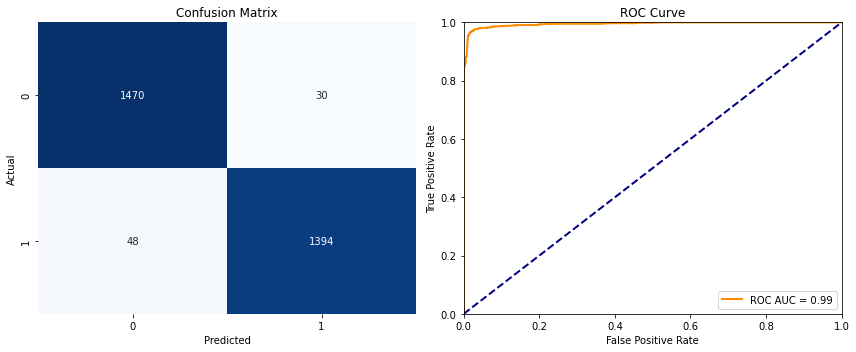

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.056847,0.967709,0.970650,0.963245,0.966934,0.967623,0.951416
2,Decision Tree - Optimized,29.725759,0.964310,0.967810,0.959085,0.963427,0.964209,0.145982
3,Random Forest - Basic,0.703933,0.971788,0.974180,0.968100,0.971130,0.971717,0.211232
4,Random Forest - Optimized,208.256151,0.973487,0.978933,0.966713,0.972784,0.973356,0.089271


In [22]:
# Let us check performance
model = best_rf_classifier
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
- Damn Nice! LogLoss is now only 0.09!
- Other parameters also look great. 

# Logistic Regression - Basic Model


In [23]:
model_name = "Logistic Regression - Basic"
# Start measuring time
start_time = time.time()

# Create a Logistic Regression model
logistic_model = LogisticRegression(random_state=1, max_iter=1000)

# Train the model on the training data
logistic_model.fit(X_train, y_train)

# Stop measuring time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)


Elapsed Time: 0.11125493049621582


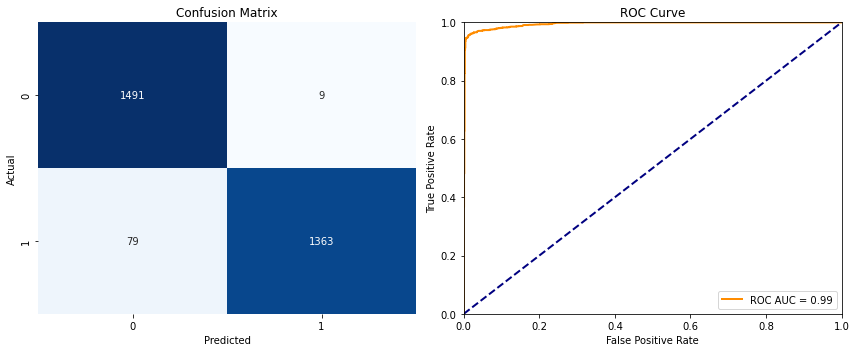

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.056847,0.967709,0.970650,0.963245,0.966934,0.967623,0.951416
2,Decision Tree - Optimized,29.725759,0.964310,0.967810,0.959085,0.963427,0.964209,0.145982
3,Random Forest - Basic,0.703933,0.971788,0.974180,0.968100,0.971130,0.971717,0.211232
4,Random Forest - Optimized,208.256151,0.973487,0.978933,0.966713,0.972784,0.973356,0.089271
5,Logistic Regression - Basic,0.111255,0.970088,0.993440,0.945215,0.968728,0.969607,0.088022


In [24]:
# Let us check performance
model = logistic_model
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Obsrvation:
- Off the shelf Logistic Regression is very very nice! 
- LogLoss is under 0.09 --even without hyperparamter tuning.

## Optimized Logistic Regression

We will want to optimize to LogLoss (negative log Loss, since the optimizer is mazimizing the function)

In [25]:
model_name = "Logistic Regression - Optimized"

# Start measuring time
start_time = time.time()

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [5000, 10000]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(random_state=1), 
                           param_grid,
                           cv=5,
                           verbose=2,
                           n_jobs=-1,
                          scoring='neg_log_loss'
                          )

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Stop measuring time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Retrieve the best hyperparameters and the best estimator
best_params = grid_search.best_params_
best_lr = grid_search.best_estimator_

# Print Training / Search time and Best Hyperparameters
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Elapsed Time: 290.1474099159241
Best Hyperparameters: {'C': 1, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'liblinear'}


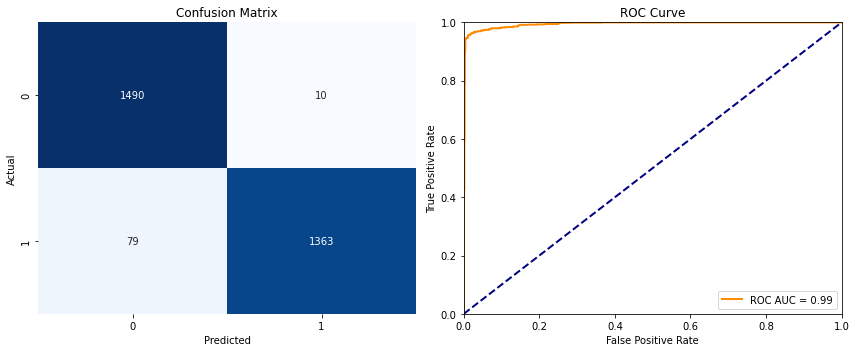

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.056847,0.967709,0.970650,0.963245,0.966934,0.967623,0.951416
2,Decision Tree - Optimized,29.725759,0.964310,0.967810,0.959085,0.963427,0.964209,0.145982
3,Random Forest - Basic,0.703933,0.971788,0.974180,0.968100,0.971130,0.971717,0.211232
4,Random Forest - Optimized,208.256151,0.973487,0.978933,0.966713,0.972784,0.973356,0.089271
5,Logistic Regression - Basic,0.111255,0.970088,0.993440,0.945215,0.968728,0.969607,0.088022
6,Logistic Regression - Optimized,290.147410,0.969748,0.992717,0.945215,0.968384,0.969274,0.088596


In [26]:
# Let us check performance
model = best_lr
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
- Not much of ain improvement by optimizing logistic regression.

# KNN - Basic

In [27]:
model_name = "KNN - Basic"

# instantiate the model (using the default parameters)
KNN = KNeighborsClassifier()

# Start the timer
start_time = time.time()

# fit the model with data
KNN.fit(X_train, y_train)

# End the timer
end_time = time.time()

# Calculate the difference
elapsed_time = end_time - start_time

print('Elapsed Time:', elapsed_time)

y_pred = KNN.predict(X_test)
KNN_score_train = KNN.score(X_train, y_train)
KNN_score_test = KNN.score(X_test, y_test)
print('KNN Score Train:', KNN_score_train)
print('KNN Score Test:', KNN_score_test)

Elapsed Time: 0.006979942321777344
KNN Score Train: 0.9793063246866802
KNN Score Test: 0.9683888511216859


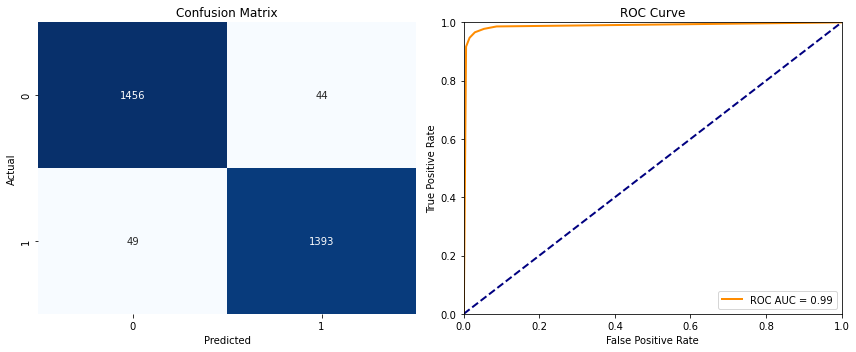

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.056847,0.967709,0.970650,0.963245,0.966934,0.967623,0.951416
2,Decision Tree - Optimized,29.725759,0.964310,0.967810,0.959085,0.963427,0.964209,0.145982
3,Random Forest - Basic,0.703933,0.971788,0.974180,0.968100,0.971130,0.971717,0.211232
4,Random Forest - Optimized,208.256151,0.973487,0.978933,0.966713,0.972784,0.973356,0.089271
5,Logistic Regression - Basic,0.111255,0.970088,0.993440,0.945215,0.968728,0.969607,0.088022
6,Logistic Regression - Optimized,290.147410,0.969748,0.992717,0.945215,0.968384,0.969274,0.088596
7,KNN - Basic,0.006980,0.968389,0.969381,0.966019,0.967697,0.968343,0.384587


In [28]:
# Let us check performance
model = KNN
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observations:
- Not the best performace for the out of box KNN compared to some other models

# KNN - Optimized

In [29]:
model_name = "KNN - Optimized"

# Define the hyperparameters and their possible values
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Start the timer
start_time = time.time()

# Create a GridSearchCV object
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='neg_log_loss'
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Print the best parameters
print("Best hyperparameters:", grid_search.best_params_)

# Refit the KNN model using the best hyperparameters
best_knn = grid_search.best_estimator_

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Elapsed Time: 61.62224888801575
Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}


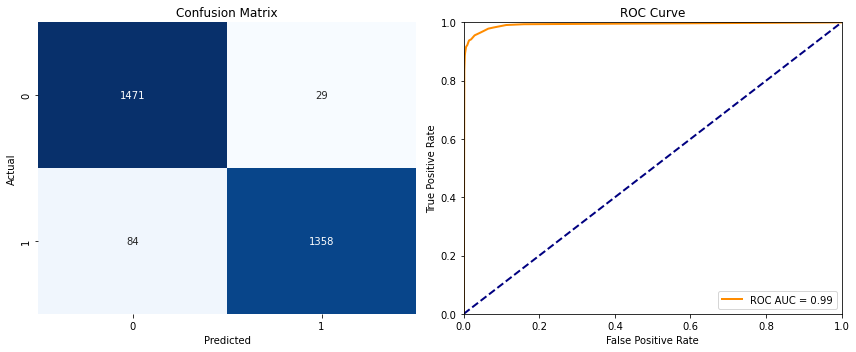

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.056847,0.967709,0.970650,0.963245,0.966934,0.967623,0.951416
2,Decision Tree - Optimized,29.725759,0.964310,0.967810,0.959085,0.963427,0.964209,0.145982
3,Random Forest - Basic,0.703933,0.971788,0.974180,0.968100,0.971130,0.971717,0.211232
4,Random Forest - Optimized,208.256151,0.973487,0.978933,0.966713,0.972784,0.973356,0.089271
5,Logistic Regression - Basic,0.111255,0.970088,0.993440,0.945215,0.968728,0.969607,0.088022
6,Logistic Regression - Optimized,290.147410,0.969748,0.992717,0.945215,0.968384,0.969274,0.088596
7,KNN - Basic,0.006980,0.968389,0.969381,0.966019,0.967697,0.968343,0.384587
8,KNN - Optimized,61.622249,0.961591,0.979092,0.941748,0.960057,0.961207,0.199948


In [30]:
# Let us check performance
model = best_knn
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

# Basic SVM

In [31]:
model_name = "SVM - Basic"

# Start the timer
start_time = time.time()

# Create the SVC model with probability enabled
svc = SVC(probability=True, random_state=42)
svc.fit(X_train, y_train)

# End the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

Elapsed Time: 5.332732200622559


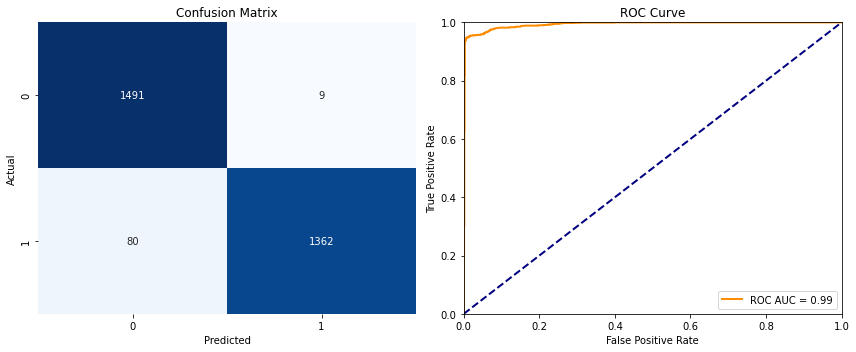

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.056847,0.967709,0.970650,0.963245,0.966934,0.967623,0.951416
2,Decision Tree - Optimized,29.725759,0.964310,0.967810,0.959085,0.963427,0.964209,0.145982
3,Random Forest - Basic,0.703933,0.971788,0.974180,0.968100,0.971130,0.971717,0.211232
4,Random Forest - Optimized,208.256151,0.973487,0.978933,0.966713,0.972784,0.973356,0.089271
5,Logistic Regression - Basic,0.111255,0.970088,0.993440,0.945215,0.968728,0.969607,0.088022
6,Logistic Regression - Optimized,290.147410,0.969748,0.992717,0.945215,0.968384,0.969274,0.088596
7,KNN - Basic,0.006980,0.968389,0.969381,0.966019,0.967697,0.968343,0.384587
8,KNN - Optimized,61.622249,0.961591,0.979092,0.941748,0.960057,0.961207,0.199948
9,SVM - Basic,5.332732,0.969748,0.993435,0.944521,0.968361,0.969261,0.106984


In [32]:
# Let us check performance
model = svc
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
 - Not a bad Log Loss out of the box for SVM!

# SVM - Optimized

In [33]:
model_name = "SVM - Optimized"

# Start the timer
start_time = time.time()

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid']  # Specifies the kernel type to be used in the algorithm
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),  # Enable probability for ROC AUC
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='neg_log_loss'  # Optimize for LogLoss
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Get the best estimator (best model)
best_svc = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Elapsed Time: 1220.5719089508057
Best Hyperparameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


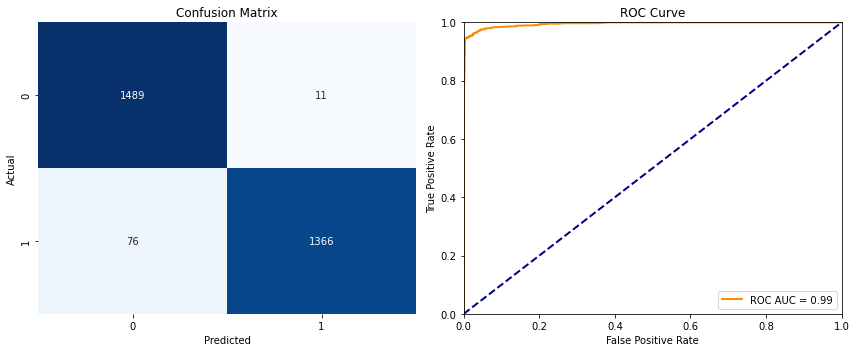

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.056847,0.967709,0.970650,0.963245,0.966934,0.967623,0.951416
2,Decision Tree - Optimized,29.725759,0.964310,0.967810,0.959085,0.963427,0.964209,0.145982
3,Random Forest - Basic,0.703933,0.971788,0.974180,0.968100,0.971130,0.971717,0.211232
4,Random Forest - Optimized,208.256151,0.973487,0.978933,0.966713,0.972784,0.973356,0.089271
5,Logistic Regression - Basic,0.111255,0.970088,0.993440,0.945215,0.968728,0.969607,0.088022
6,Logistic Regression - Optimized,290.147410,0.969748,0.992717,0.945215,0.968384,0.969274,0.088596
7,KNN - Basic,0.006980,0.968389,0.969381,0.966019,0.967697,0.968343,0.384587
8,KNN - Optimized,61.622249,0.961591,0.979092,0.941748,0.960057,0.961207,0.199948
9,SVM - Basic,5.332732,0.969748,0.993435,0.944521,0.968361,0.969261,0.106984


In [34]:
# Let us check performance
model = best_svc
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observations:
- SVM Grid Seach took a long time
- LogLoss improved slightly: from 0.11 to 0.1

## Observation
- A decent improvement in LogLoss

# Summary

In [35]:
performance_df

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000998,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.056847,0.967709,0.970650,0.963245,0.966934,0.967623,0.951416
2,Decision Tree - Optimized,29.725759,0.964310,0.967810,0.959085,0.963427,0.964209,0.145982
3,Random Forest - Basic,0.703933,0.971788,0.974180,0.968100,0.971130,0.971717,0.211232
4,Random Forest - Optimized,208.256151,0.973487,0.978933,0.966713,0.972784,0.973356,0.089271
5,Logistic Regression - Basic,0.111255,0.970088,0.993440,0.945215,0.968728,0.969607,0.088022
6,Logistic Regression - Optimized,290.147410,0.969748,0.992717,0.945215,0.968384,0.969274,0.088596
7,KNN - Basic,0.006980,0.968389,0.969381,0.966019,0.967697,0.968343,0.384587
8,KNN - Optimized,61.622249,0.961591,0.979092,0.941748,0.960057,0.961207,0.199948
9,SVM - Basic,5.332732,0.969748,0.993435,0.944521,0.968361,0.969261,0.106984


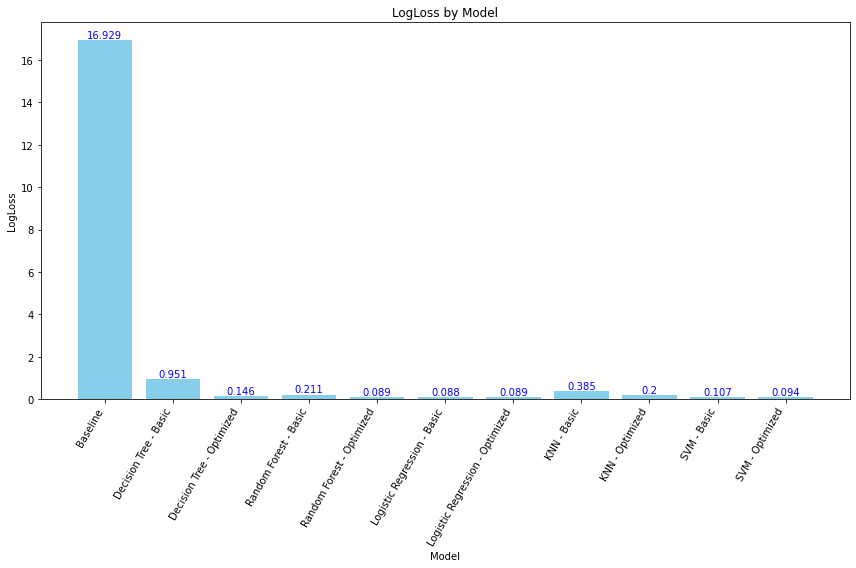

In [36]:
# Plotting the bar graph for LogLoss by Model with annotations
plt.figure(figsize=(12, 8))
bars = plt.bar(performance_df['Model Name'], performance_df['Log Loss'], color='skyblue')

# Adding the text annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', color='blue')

plt.xlabel('Model')
plt.ylabel('LogLoss')
plt.title('LogLoss by Model')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


In [37]:
#Let us export the performance datafraome to .csv
performance_df.to_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\performance_df.csv", index=False)